In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\l\Anaconda3N\envs\ai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None,real_dim), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None,z_dim), name="input_z")
    
    return inputs_real, inputs_z

In [9]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope("generator", reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha*h1,h1)
        
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [10]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope("discriminator",reuse=reuse):
        h1 = tf.layers.dense(x, n_units, activation=None)
        h1 = tf.maximum(h1*alpha,h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [11]:
input_size=784
z_size=100
g_hidden_size=128
d_hidden_size=128
alpha=0.01
smooth=0.1

In [12]:
tf.reset_default_graph()
input_real, input_z = model_inputs(input_size, z_size)
g_model = generator(input_z, input_size,n_units=g_hidden_size,alpha=alpha)

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size,alpha=alpha)

In [14]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1-smooth)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)*(1-smooth)))

d_loss = d_loss_real + d_loss_fake
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)*(1-smooth)))

In [15]:
lr = 0.002

t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
g_vars = [var for var in t_vars if var.name.startswith("generator")]

d_train_opt = tf.train.AdamOptimizer(lr).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(lr).minimize(g_loss, var_list=g_vars)


In [17]:
batch_size= 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size,784))
            batch_images = batch_images*2-1
            
            batch_z = np.random.uniform(-1,1,size=(batch_size,z_size))
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
            

Epoch 1/100... Discriminator Loss: 0.3728... Generator Loss: 3.1004
Epoch 2/100... Discriminator Loss: 0.3472... Generator Loss: 4.1480
Epoch 3/100... Discriminator Loss: 0.5124... Generator Loss: 5.1995
Epoch 4/100... Discriminator Loss: 0.7329... Generator Loss: 2.7857
Epoch 5/100... Discriminator Loss: 0.7673... Generator Loss: 3.2703
Epoch 6/100... Discriminator Loss: 0.7494... Generator Loss: 4.6565
Epoch 7/100... Discriminator Loss: 0.6966... Generator Loss: 2.2251
Epoch 8/100... Discriminator Loss: 1.1784... Generator Loss: 1.8587
Epoch 9/100... Discriminator Loss: 0.8317... Generator Loss: 1.7435
Epoch 10/100... Discriminator Loss: 0.9525... Generator Loss: 2.3043
Epoch 11/100... Discriminator Loss: 1.3404... Generator Loss: 2.1236
Epoch 12/100... Discriminator Loss: 1.3215... Generator Loss: 2.7735
Epoch 13/100... Discriminator Loss: 1.0911... Generator Loss: 2.3250
Epoch 14/100... Discriminator Loss: 0.8074... Generator Loss: 2.8552
Epoch 15/100... Discriminator Loss: 1.1956.

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

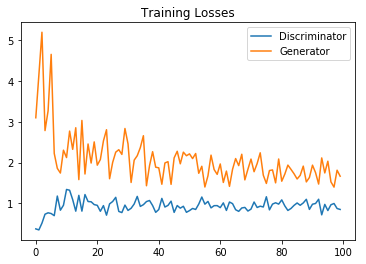

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [20]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [21]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

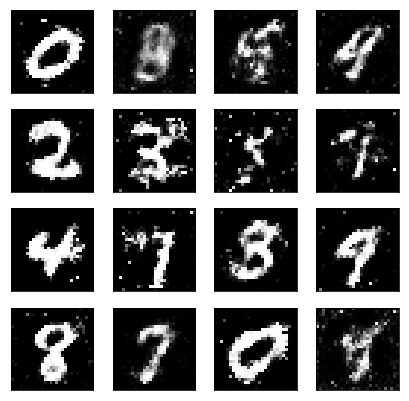

In [22]:
_ = view_samples(-1, samples)